In [79]:
import numpy as np
import pandas as pd 
import seaborn as sns 
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import defaultdict

$\Large{\textbf{Black-Scholes-Merton Model}}$

The Black-Scholes-Merton model is a mathematical model to calculate the price of the european options. (https://en.wikipedia.org/wiki/Black–Scholes_model). Solving the Black-Scholes equation provides a theoretical estimate for the price of european call and put options.   

$\textbf{Call Option Price} \:\: C =  S_0 \: e^{-y T} \: N(d_1) - K \: e^{-rT} \: N(d_2)$


$\textbf{Put Option Price} \:\:\: P = K \: e^{-rT} \: N(-d_2) - S_0 \: e^{-y T} \: N(-d_1) $

where 

$S_0$ = Current share price  
    
$K$ = strike price (https://en.wikipedia.org/wiki/Strike_price) 
    
$T$ = time to maturity in years 
    
$r$ = risk-free rate (https://en.wikipedia.org/wiki/Interest_rate)
    
$y$ = dividend yield  (https://en.wikipedia.org/wiki/Dividend_yield)
    
$\sigma$ = Volatility  (https://en.wikipedia.org/wiki/Volatility_(finance))

and $N(x)$ is the cdf of a standard normal distribution with $d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{σ^2}{2})T}{σ\sqrt{T}}$ , $d_2 = d_1 - σ\sqrt{T}  $

    

In [49]:
def black_scholes_option(S, K, T, r, y, sigma, option):

    d1= (np.log(S /K) + (r-y + 0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    
    if option=="call":
        price = S* np.exp(-y*T)* norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price= K* np.exp(-r*T)* norm.cdf(-d2) - S* np.exp(-y*T)* norm.cdf(-d1)
       
    return price

$\Large{\textbf{Monte Carlo Simulation}}$

The stock price follows the stochastic differential equation

$dS = \mu \: S \: dt + \sigma \: S \: dW$

where $W$ is a weiner process. This can be solved to give the stock price at maturity $T$

$S_T = S_0 \: e^{(r-\frac{\sigma^2}{2})T + \sigma W(T) } $ 

where $W(T)= \sqrt{T} \: Z(0,1)$ is a normal distribution with variance T. For a stock that pays dividends the stock price is given by 

$S_T = S_0 \: e^{(r- y -\frac{\sigma^2}{2})T + \sigma W(T) } $ 

The payoff of a call option is given by $max(S_T-K,0)$ whereas for a put option the payoff is $max(K-S_T,0)$. 

In a monte-carlo simulation, we simulate the stock price at maturity for M paths and average over them to calculate the final payoff.

$C = e^{-r T} \frac{\sum_{i=1}^M max(S_{T,i} - K,0)}{M}$ 
$P = e^{-r T} \frac{\sum_{i=1}^M max(K - S_{T,i},0)}{M}$ 

where $S_{T,i}$ is the stock price at maturity for the $i^{th}$ simulation.  

Note: In general one needs to calculate the stock price iteratively but for the case of european options, one can just simulate ove the stock price at maturity  

In [51]:
def monte_carlo_option_pricing(S, K, T, r, y, sigma, num_simulations=10000, option='call'):
   
   
    Z = np.random.standard_normal(num_simulations)
    
    ST = S * np.exp((r - y - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    if option == 'call':
        payoff = np.maximum(ST - K, 0)
    else:  
        payoff = np.maximum(K - ST, 0)
    
    price = np.exp(-r * T) * np.mean(payoff)
    
    std_error = np.exp(-r * T) * np.std(payoff) / np.sqrt(num_simulations)
    
    return price, std_error

We now compare the two methods by simulating the option price using Monte Carlo for increasing number of simulation points and show that it converges to the theoretical value as predicted by the Black-Scholes equation.


In [53]:
def BS_MC_convergence(S, K, T, r, y, sigma, option):
 
    simulation_points = np.logspace(3, 7, 10, dtype=int)  
    
    prices = []
    errors= []
    
    if option=="call":
        
        for num in simulation_points:
            
            price, error = monte_carlo_option_pricing(S, K, T, r, y, sigma, num, 'call')
        
            prices.append(price)
            errors.append(1.96*error)
        
        fig = plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=simulation_points, y=prices, label='Monte Carlo')
        ax.errorbar(x=simulation_points, y=prices, yerr=errors,ecolor='black',fmt="none",capsize=3)
        ax.axhline(y=BS_call_price, color='red',label='Black-Scholes')
        ax.set_xscale('log')
        ax.set_xlabel('Number of Simulations')
        ax.set_ylabel('Option Price ($)')
        ax.set_title('Call Option: Monte Carlo Convergence', fontsize=14, fontweight='bold')
        ax.legend()
        
    else:
        
        for num in simulation_points:
           
            price, error = monte_carlo_option_pricing(S, K, T, r, y, sigma, num, 'put')
    
            prices.append(price)
            errors.append(1.96*error)

        
        fig = plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=simulation_points, y=prices, label='Monte Carlo')
        ax.errorbar(x=simulation_points, y=prices, yerr=errors,ecolor='black',fmt="none",capsize=3)
        ax.axhline(y=BS_put_price, color='red', label='Black-Scholes')
        ax.set_xscale('log')
        ax.set_xlabel('Number of Simulations')
        ax.set_ylabel('Option Price ($)')
        ax.set_title('Put Option: Monte Carlo Convergence', fontsize=14, fontweight='bold')
        ax.legend()


The parameters for the model are 

In [55]:
S = 100
K = 120 
T = 1
r = 0.08
sigma = 0.2
y = 0
option = "call"

Run this cell to visualize the predictions of both methods.

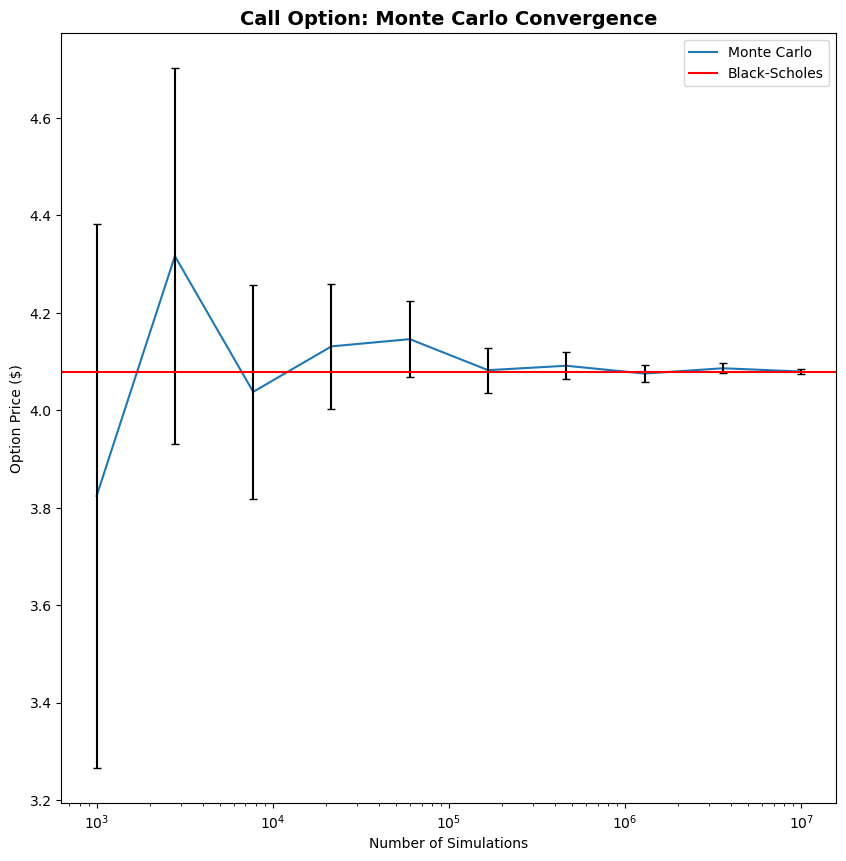

In [63]:
BS_call_price = black_scholes_option(S, K, T, r, y, sigma,'call')
BS_put_price  = black_scholes_option(S, K, T, r, y, sigma,'put')

BS_MC_convergence(S, K, T, r, y, sigma, option)

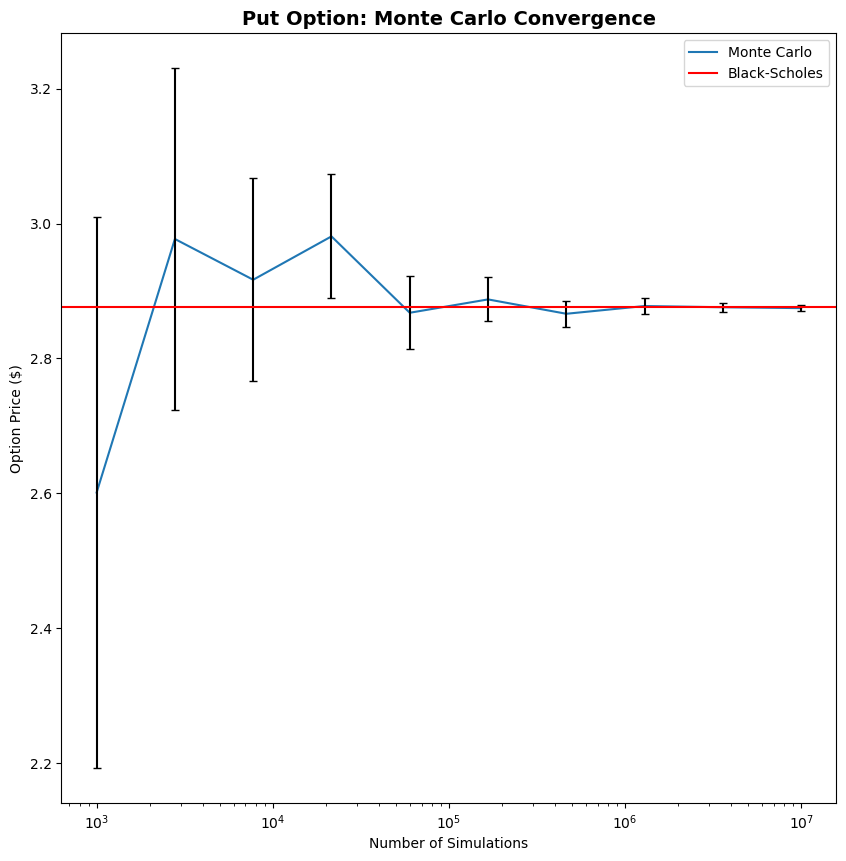

In [65]:
S = 130
K = 120 
T = 1
r = 0.08
sigma = 0.2
y = 0
option = "put"

BS_call_price = black_scholes_option(S, K, T, r, y, sigma,'call')
BS_put_price  = black_scholes_option(S, K, T, r, y, sigma,'put')

BS_MC_convergence(S, K, T, r, y, sigma, option)

This is cool ! Though the errors seem to be pretty  large. Lets employ some variance reduction to reduce these errors. The first one we will use antithetic variables. Here instead of generating N random numbers from a normal distribution, we draw a pair of N/2 negatively correlated variables. This reduces the variance since if two variables X and Y are negatively correlated, then 

$Var(X+Y) = Var(X) + Var(Y) + 2*Cov(X,Y) < Var(X) + Var(Y) $ 



In [125]:
def antithetic_monte_carlo(S, K, T, r, y, sigma, num_simulations, option):

    Z = np.random.standard_normal(num_simulations//2)

    Z = np.concatenate([Z, -Z])
    
    ST = S * np.exp((r - y - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    if option == 'call':
        payoff = np.maximum(ST - K, 0)
    else:  
        payoff = np.maximum(K - ST, 0)
    
    price = np.exp(-r * T) * np.mean(payoff)
    
    std_error = np.exp(-r * T) * np.std(payoff) / np.sqrt(num_simulations)

    return price, std_error

We will also consider the control variate model for variance reduction. In this method, one uses a correlated instrument with a known estimate (lets call it $C$ with $E[C]=C^*$) and choses a model such that it minimizes the variance of the target. For example, for our target, which is an european option (lets call it $m$) , one can use an estimator $m^*$

$m^* = m + \beta (C-C^*)$

with the expected value $m$ and variance $Var(m^*)=Var(m)+ \beta^2 Var(C) + 2 \beta*Cov(m,C)$. One can minimize the variance by choosing $\beta=-\frac{Cov(m,C)}{Var(C)}$ such that $Var(m^*)=(1-\rho^2)Var(m)$, where $\rho$ is the correlation between $m$ and $C$. 
Hence by maximizing the correlation with the control, one can minimize the variance of the target. 

For vanilla european options, one usually uses geometric asian options as control since the analytic price is known.

In [162]:
def control_variate_monte_carlo(S, K, T, r, y, sigma, num_simulations, option):

    n=100
    dt=T/n

    St = np.zeros((num_simulations, n + 1))
    St[:, 0] = S
    
    for j in range(n):
        
        Z=np.random.standard_normal(num_simulations)
        St[:,j+1]=St[:,j]*np.exp((r - y - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    ST=St[:,-1]
    
    if option == 'call':
        payoff = np.maximum(ST - K, 0)
    else:  
        payoff = np.maximum(K - ST, 0)

    #Control option
    Sc = np.exp(np.mean(np.log(St[:, 1:]), axis=1))
    
    if option == 'call':
        payoff_c = np.maximum(Sc-K, 0)
    else:
        payoff_c = np.maximum(K-Sc, 0)
        
    # Known analytical value for geometric Asian (approximation)
    sigma_c = sigma / np.sqrt(3)
    r_c = 0.5 * (r - y - (sigma**2) / 6)
        
    BS_control = black_scholes_option(S, K, T, r_c, y, sigma_c, option)  
        
    discount_factor = np.exp(-r*T)
        
        
    cov = np.cov(payoff, payoff_c)[0, 1]
    var_c = np.var(payoff_c)
        
    beta = - cov / var_c if var_c > 0 else 0
        
    payoff_new = payoff + beta * (payoff_c - BS_control/ discount_factor)
         
    price = np.exp(-r*T)*np.mean(payoff_new)
    std_error = np.exp(-r*T)*np.std(payoff_new) / np.sqrt(num_simulations)
        
    return price, std_error
    

In [164]:
def BS_MC_convergence_reduced(S, K, T, r, y, sigma, option):
   
    simulation_points = np.logspace(3, 7, 10, dtype=int)  

    BS_price=black_scholes_option(S, K, T, r, y, sigma, option)
    
    dict_prices=defaultdict(list)
    dict_errors=defaultdict(list)
    
    for num in simulation_points:
           
        price, error = monte_carlo_option_pricing(S, K, T, r, y, sigma, num, option)
    
        dict_prices["None"].append(price)
        dict_errors["None"].append(1.96*error)

        price, error = antithetic_monte_carlo(S, K, T, r, y, sigma, num, option)
    
        dict_prices["antithetic"].append(price)
        dict_errors["antithetic"].append(1.96*error)

        price, error = control_variate_monte_carlo(S, K, T, r, y, sigma, num, option)
    
        dict_prices["cv"].append(price)
        dict_errors["cv"].append(1.96*error)

        
    plt.figure(figsize=(10, 10))

    for method in ["None","antithetic","cv"]:
        ax=sns.lineplot(x=simulation_points, y=dict_prices[method], label=method)
        #ax.errorbar(x=simulation_points, y=dict_prices[method], yerr=dict_errors[method],ecolor='black',fmt="none",capsize=3)
    
    ax.axhline(y=BS_price, color='red', label='Black-Scholes')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Simulations')
    ax.set_ylabel('Option Price ($)')
    ax.set_title(f'{option} Option: Monte Carlo Convergence', fontsize=14, fontweight='bold')
    ax.legend()

    plt.figure(figsize=(10, 10))
    for method in ["None","antithetic","cv"]:
        ax=sns.lineplot(x=simulation_points, y=dict_errors[method], label=method)
        #ax.errorbar(x=simulation_points, y=dict_prices[method], yerr=dict_errors[method],ecolor='black',fmt="none",capsize=3)
    
    #ax.axhline(y=BS_price, color='red', label='Black-Scholes')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Simulations')
    ax.set_ylabel('Standard error($)')
    ax.set_title(f'{option} Option: Standard error reduction', fontsize=14, fontweight='bold')
    ax.legend()

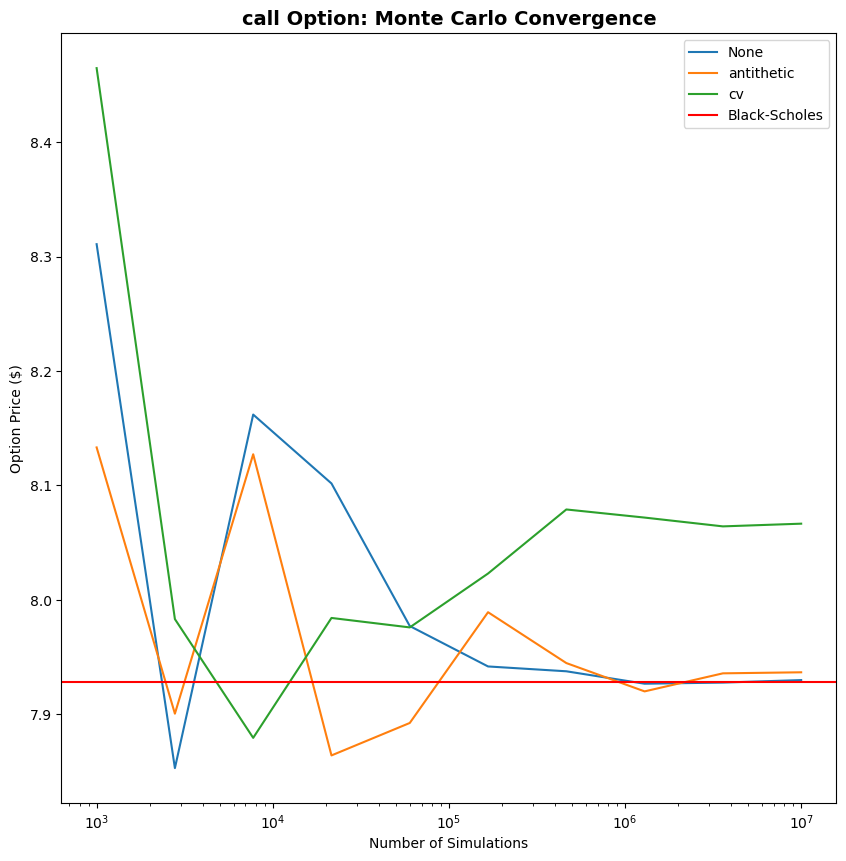

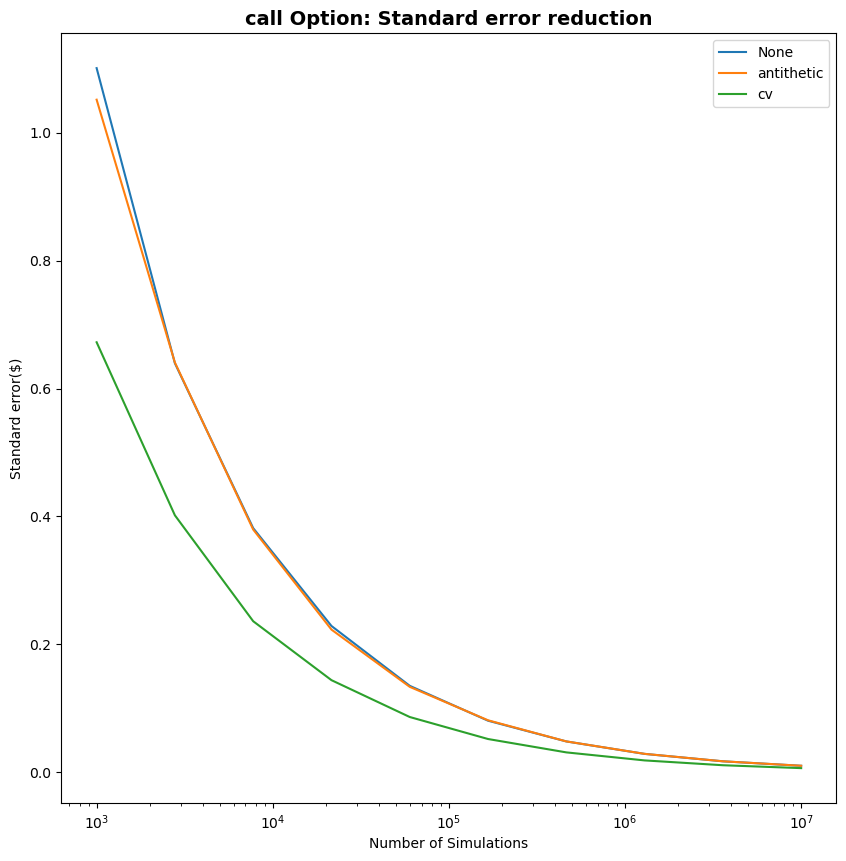

In [166]:
S = 100
K = 120 
T = 2 
r = 0.05
sigma = 0.2
y = 0
option = "call"
BS_MC_convergence_reduced(S, K, T, r, y, sigma, option)